In [1]:
cd /Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo/

/Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo


In [2]:
import numpy as np
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as cl
from matplotlib.gridspec import GridSpec as gs
import networkx as nx
import seaborn as sns
import miniSAFE as ms
import OMEGA_core as om

In [6]:
# load dataframe
# load dataframe
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')

# load data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'
reshaped = np.load(dest_folder+'NMF_regrouped.npy')
h = np.load(dest_folder+'NMF_basis.npy')
w = np.load(dest_folder+'NMF_encoding.npy')
snf_data = pk.load(open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SNF_output/SNF_output.pk','rb'))
n_components = 20
positions = snf_data['positions']
g = snf_data['network']
pos = snf_data['embedding']
graph = snf_data['composite_graph']
func_tab = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/func_annot.xlsx',index_col='Functional_category')



safe_dict = pk.load(open( "/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SAFE/SAFE_dict.pk", "rb" ))
gematria_input = np.load('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/packed_rep1_spikein.npy')
gematria_input_filtered = gematria_input[df['Original_index'].values]
graph_data = snf_data['composite_graph']

In [3]:
def single_geneset_enrichment(input_df,input_graph,geneset,edge_weight_percentage_cutoff=90,
                              input_locus_key = 'locus',geneset_locus_key='locus',pval_cutoff=0.05):
    
    from scipy import stats
    from statsmodels.stats.multitest import fdrcorrection
    locus_list = input_df['locus'].values
    target_list = geneset[input_locus_key].values
    overlap = np.intersect1d(locus_list,target_list)
    target_found = np.isin(locus_list, overlap)*1

    binary_graph = (graph_data>np.percentile(input_graph,
                                             edge_weight_percentage_cutoff))*1
    M=np.sum(np.ones(binary_graph.shape),axis=1)-1
    N=np.sum(binary_graph,axis=1)
    n=np.ones(len(target_found))*(target_found.sum())
    k=binary_graph.dot(target_found)
    fdr = fdrcorrection(stats.hypergeom.sf(k-1,M,n,N))
    enriched = np.where(fdr[1]<pval_cutoff)[0]
    neglog10 = -np.log10(fdr[1])
    return target_found, fdr, enriched, neglog10

def format_names(name_list):
    new_names = []
    for n in name_list:
        if n.startswith('MSMEG'):
            new_names.append(n.split('_')[1])
        elif n in ['mScarlet','mNeonGreen']:
            new_names.append(n)
        else:
            new_names.append(n[0].capitalize()+n[1:])
    return new_names

def zoom_in(x,y,xmin,xmax,ymin,ymax):
    return np.where((x>=xmin)&(x<xmax)&(y>=ymin)&(y<ymax))[0]

def sorted_barchart(ax,entry_list,
                    colors,
                    dataframe,
                    encoding_matrix,
                    feature_id):
    feature_mean = []
    feature_std = []
    labels = []
    for i in entry_list:
        d = encoding_matrix[i*10:i*10+10,feature_id]
        feature_mean.append(np.median(d))
        feature_std.append(d.std())
        labels.append(dataframe.iloc[i]['name'])
        
    feature_mean = np.array(feature_mean)
    feature_std = np.array(feature_std)
    labels = np.array(labels)
    ranks = np.argsort(feature_mean)
    for j in range(len(entry_list)):
        ax.bar(x=j+1,height=feature_mean[ranks[j]],fc=colors[ranks[j]])
        ax.text(x=j+1,y=feature_mean[ranks[j]]+0.001,s=labels[ranks[j]],
                rotation=90,va='bottom',ha='center')
    return ax,feature_mean

def significance_label(pval):
    label = ''
    if pval < 0.05:
        label = '*'
    if pval < 0.01:
        label = '**'
    if pval < 0.001:
        label = '***'
    if pval < 0.0001:
        label = '****'
    return label


def min_max_normalization(data, pad=0, sat=1,min_cutoff=0):
    sat_p = np.percentile(data,sat*100)
    min_p = np.percentile(data,min_cutoff*100)
    norm_d = ((data-min_p)/(sat_p-min_p)+pad)/(1+pad)
    norm_d[norm_d>1]=1
    norm_d[norm_d<pad]=pad
    return norm_d

def pdf(ax,data,minx,maxx,color,alpha,bandwidth=0.2,orientation='h'):
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data.reshape(-1,1))
    L = np.linspace(minx,maxx,200)
    pdf = np.exp(kde.score_samples(L.reshape(-1,1)))
    if orientation=='v':
        ax.plot(pdf,L,color=color,alpha=alpha)
    else:
        ax.plot(L,pdf,color=color,alpha=alpha)
    return ax


In [4]:
curated_oxphos = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/OXPHOS.xls')
cog = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog_filtered.xls')
ATP_set = cog[cog['Functional_category']=='C']

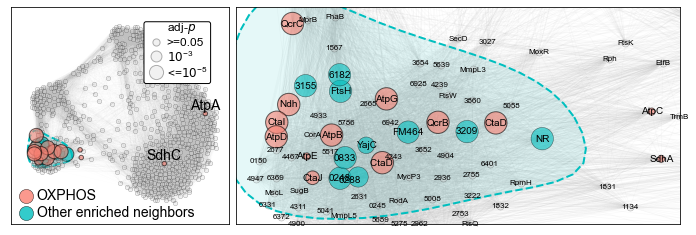

In [49]:
from matplotlib.patches import FancyBboxPatch



target_found, fdr, enriched, neglog10 = single_geneset_enrichment(df, graph_data,
                                                                  curated_oxphos, pval_cutoff=0.05,
                                                                  edge_weight_percentage_cutoff=99)
fig=plt.figure(figsize=(12,4))
grids = gs(1,9,wspace=0.1,hspace=0.05)
ax1 = fig.add_subplot(grids[0,:3])
ax2 = fig.add_subplot(grids[0,3:])
#ax3 = fig.add_subplot(grids[0,8:])

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])



sizes = neglog10 / 5
sizes[sizes<-np.log10(0.05)/5] = 0.1
sizes[sizes>1]=1

edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.05, ax=ax1)

enriched_neighbors = np.where((target_found==0)&(sizes>0.1))[0]
outgroup = np.where((target_found==0)&(sizes==0.1))

cog_atp=[]
remnant_enriched=[]

for e in enriched_neighbors:
    locus = str(df.iloc[e]['locus'])
    if locus in ATP_set['locus'].values:
        cog_atp.append(e)
    else:
        remnant_enriched.append(e)
cog_atp=np.array(cog_atp)
remnant_enriched=np.array(remnant_enriched)

ax1.scatter(positions[0,remnant_enriched],positions[1,remnant_enriched],
            c='c',
            alpha=0.6,ec='black',lw=1,
            s=sizes[remnant_enriched]*200,zorder=2)
"""
ax1.scatter(positions[0,cog_atp],positions[1,cog_atp],
            c='orange',
            alpha=0.6,ec='black',lw=1,
            s=sizes[cog_atp]*200,zorder=2)
"""
ax1.scatter(positions[0,target_found==1],positions[1,target_found==1],
            c='salmon',
            alpha=0.6,ec='black',lw=1,
            s=sizes[target_found==1]*200,zorder=3)


ax1.scatter(positions[0,outgroup],positions[1,outgroup],
            c='lightgrey',
            alpha=0.3,ec='black',lw=0.5,
            s=20,zorder=2)

for r in np.where(target_found==1)[0]:
    if positions[0,r] > -0.1:
        name = df.iloc[r]['name']
        ax1.text(positions[0,r],positions[1,r]+0.01,format_names([name])[0],
                 fontname='Arial',fontsize=14,ha='center',va='bottom')
    
ax1 = ms.polygon_to_density(ax1,positions[0,sizes>0.1],positions[1,sizes>0.1],alpha_max=0.2,ngrid=100,
                            basecolor='c',outline_lw = 2,outline_ls='--',smooth_outline=10)
ax2 = ms.polygon_to_density(ax2,positions[0,sizes>0.1],positions[1,sizes>0.1],alpha_max=0.0,
                            ngrid=100,
                            basecolor='c',outline_lw = 2,outline_ls='--',smooth_outline=10)

ax1.set_xlim(-1.2,0.9)
ax1.set_ylim(-0.85,1.05)

label_box = FancyBboxPatch((0.1,0.4),height=0.5,width=0.6,boxstyle='Round,pad=0.02',
                            fc='white',ec='black',zorder=4)
ax1.add_artist(label_box)
ax1.text(-0.85+1.15,0.84,'adj-$\it{p}$',zorder=5,fontname='Arial',fontsize=12)

vals = [-np.log10(0.05)/5, -np.log10(0.001)/5,-np.log10(0.00001)/5]
texts = ['>=0.05', '$10^\mathregular{-3}$','<=$10^\mathregular{-5}$']
labelsizes = np.array(vals)*200
for counter,y in enumerate([0.74,0.62,0.48]):
    ax1.scatter(-0.95+1.15,y,s=labelsizes[counter],fc='lightgrey', ec='black',lw=1,alpha=0.3,zorder=6)
    ax1.text(-0.85+1.15,y,'{}'.format(texts[counter]),ha='left',va='center',fontname='Arial',fontsize=12,zorder=6)
    
ax1.text(-0.95,-0.6,'OXPHOS',fontname='Arial',fontsize=14,zorder=6,ha='left',va='center')
ax1.scatter(-1.05,-0.6,fc='salmon',s=200,ec='black',lw=0.5,alpha=0.8)
ax1.text(-0.95,-0.75,'Other enriched neighbors',fontname='Arial',fontsize=14,zorder=6,ha='left',va='center')
ax1.scatter(-1.05,-0.75,fc='c',s=200,ec='black',lw=0.5,alpha=0.8)


ax2.set_xlim(-1.02,-0.5)
ax2.set_ylim(-0.36,-0.05)
edges2 = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.5,
                                ax=ax2)

ax2.scatter(positions[0,remnant_enriched],positions[1,remnant_enriched],
            c='c',
            alpha=0.6,ec='black',lw=0.5,
            s=sizes[remnant_enriched]*500,zorder=2)
"""
ax2.scatter(positions[0,cog_atp],positions[1,cog_atp],
            c='orange',
            alpha=0.6,ec='black',lw=0.5,
            s=sizes[cog_atp]*500,zorder=2)
""";
ax2.scatter(positions[0,target_found==1],positions[1,target_found==1],
            c='salmon',
            alpha=0.6,ec='black',lw=1,
            s=sizes[target_found==1]*500,zorder=3)

ax2.scatter(positions[0,outgroup],positions[1,outgroup],
            c='lightgrey',
            alpha=0.3,ec='black',lw=0.5,
            s=50,zorder=2)

names=format_names(df['name'].values)
selected = zoom_in(positions[0],positions[1],-1,-0.5,-0.36,-0.05)
for i in selected:
    x=positions[0,i]
    y=positions[1,i]
    s=names[i]
    if i in enriched or target_found[i]==1: 
        fontsize=10
    else:
        fontsize=8
    if s=='6288':
        x-=0.01
        y-=0.005
    ax2.annotate(s,(x,y),fontname='Arial',fontsize=fontsize,va='center',ha='center',
                 zorder=6)
    
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/atp_plots/atp_temp.png',
            dpi=100,bbox_inches='tight',transparent=True)

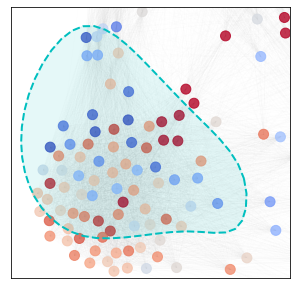

In [35]:
from matplotlib.patches import FancyBboxPatch



target_found, fdr, enriched, neglog10 = single_geneset_enrichment(df, graph_data,
                                                                  curated_oxphos, pval_cutoff=0.05,
                                                                  edge_weight_percentage_cutoff=99)
fig=plt.figure(figsize=(5,5))
#grids = gs(1,9,wspace=0.1,hspace=0.05)
ax2 = plt.subplot(111)
#ax3 = fig.add_subplot(grids[0,8:])

#ax1.set_xticks([])
#ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(-1.05,-0.53)
ax2.set_ylim(-0.2,0.22)

feature_4 = min_max_normalization(np.average(reshaped[:,:,5],axis=1),sat=0.98)
edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.1, ax=ax2)
ax2.scatter(positions[0],positions[1],c=cm.get_cmap('coolwarm')(feature_4),s=100,alpha=0.8)

                            
ax2 = ms.polygon_to_density(ax2,positions[0,sizes>0.1],positions[1,sizes>0.1],alpha_max=0.0,
                            ngrid=100,
                            basecolor='c',outline_lw = 2,outline_ls='--',smooth_outline=10)

"""
enriched_neighbors = np.where((target_found==0)&(sizes>0.1))[0]
outgroup = np.where((target_found==0)&(sizes==0.1))

cog_atp=[]
remnant_enriched=[]

for e in enriched_neighbors:
    locus = str(df.iloc[e]['locus'])
    if locus in ATP_set['locus'].values:
        cog_atp.append(e)
    else:
        remnant_enriched.append(e)
cog_atp=np.array(cog_atp)
remnant_enriched=np.array(remnant_enriched)
                   
                            
ax2 = ms.polygon_to_density(ax2,positions[0,sizes>0.1],positions[1,sizes>0.1],alpha_max=0.0,
                            ngrid=100,
                            basecolor='c',outline_lw = 2,outline_ls='--',smooth_outline=10)




edges2 = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.5,
                                ax=ax2)

ax2.scatter(positions[0,remnant_enriched],positions[1,remnant_enriched],
            c='c',
            alpha=0.6,ec='black',lw=0.5,
            s=sizes[remnant_enriched]*500,zorder=2)
ax2.scatter(positions[0,target_found==1],positions[1,target_found==1],
            c='salmon',
            alpha=0.6,ec='black',lw=1,
            s=sizes[target_found==1]*500,zorder=3)

ax2.scatter(positions[0,outgroup],positions[1,outgroup],
            c='lightgrey',
            alpha=0.3,ec='black',lw=0.5,
            s=50,zorder=2)

names=format_names(df['name'].values)
selected = zoom_in(positions[0],positions[1],-1.01,-0.5,-0.14,0.2)
for i in selected:
    x=positions[0,i]
    y=positions[1,i]
    s=names[i]
    if i in enriched or target_found[i]==1: 
        fontsize=10
    else:
        fontsize=8
    if s=='6288':
        x-=0.01
        y-=0.005
    ax2.annotate(s,(x,y),fontname='Arial',fontsize=fontsize,va='center',ha='center',
                 zorder=6)
""";
#plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/atp_plots/atp_temp.png',
           # dpi=100,bbox_inches='tight',transparent=True)

In [16]:
# plot consensus
atpstack = np.array([gematria_input[i,5,:] for i in np.where(target_found==1)[0]])
weightedstack = np.sum(atpstack*neglog10[target_found==1][:,np.newaxis],axis=0)
fig=plt.figure(figsize=(2,1))
plt.imshow(weightedstack.reshape(15,30),aspect='auto')
plt.axis('off')
#plt.title('weighted consensus\n(l=5)')
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/atp_plots/atp_weighted_consensus.png',
            dpi=100,bbox_inches='tight',transparent=True)
plt.close()

In [16]:
atp_enriched = np.where((target_found==1)&(sizes>0.1))[0]

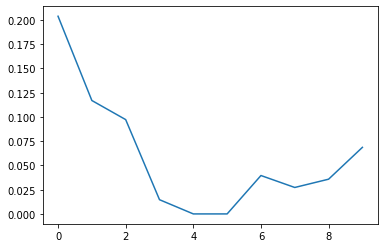

In [36]:
plt.plot(reshaped[atp_enriched,:,6][3]);

In [37]:
df.iloc[atp_enriched[3]]

New_index                           411
Original_index                      411
key               MSR_08_C11_MSMEG_4437
locus                        MSMEG_4437
name                               ctaD
image_count                           9
experiment                          MSR
replicate                             1
SAFE_input                            1
Name: 411, dtype: object

In [103]:
# compare OXPHOS proteins with other 
"""
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


colors=['salmon','c']
alpha=[0.8, 0.8]
sizes=[150,150]

feature_4_mwu=stats.mannwhitneyu(membrane[:,3],atp[:,3])
feature_6_mwu=stats.mannwhitneyu(membrane[:,6],atp[:,6])

fig=plt.figure(figsize=(4,4))
grids=gs(10,10,hspace=0.1)
ax1=fig.add_subplot(grids[:2,:8])
ax2=fig.add_subplot(grids[2:,:8])
ax3=fig.add_subplot(grids[2:,8:])
n=0

# plot membrane fraction
ax2.scatter(membrane[:,3],membrane[:,6],fc=colors[1],ec='black',lw=0.5,s=150,label='membrane')
sns.distplot(membrane[:,3], ax=ax1, color=colors[1],norm_hist=True, hist=False, rug=True,
             rug_kws={'height':0.2,'lw':2,'alpha':0.5}, kde_kws={'lw':3})
sns.distplot(membrane[:,6], ax=ax3, color=colors[1],norm_hist=True, hist=False, rug=True, 
             rug_kws={'height':0.2,'lw':2,'alpha':0.5}, kde_kws={'lw':3}, vertical=True)

# plot atp fraction
ax2.scatter(atp[:,3],atp[:,6],fc=colors[0],ec='black',lw=0.5,s=150,label='ATP biosynthesis')
sns.distplot(atp[:,3], ax=ax1, color=colors[0],norm_hist=True, hist=False, rug=True,
             rug_kws={'height':0.2,'lw':2,'alpha':0.5}, kde_kws={'lw':3})
sns.distplot(atp[:,6], ax=ax3, color=colors[0],norm_hist=True, hist=False, rug=True, 
             rug_kws={'height':0.2,'lw':2,'alpha':0.5}, kde_kws={'lw':3}, vertical=True)

ax2.set_xlabel('feature 4\n(average weight)',fontsize=16,fontname='Arial')
ax2.set_ylabel('feature 7\n(average weight)',fontsize=16,fontname='Arial')
ax2.set_xticks([0,0.05,0.1,0.15])
ax2.set_yticks([0,0.1,0.2,0.3])
ax2.set_xticklabels([0,0.05,0.1,0.15],fontsize=14,fontname='Arial')
ax2.set_yticklabels([0,0.1,0.2,0.3],fontsize=14,fontname='Arial')
ax2.legend(prop={'family':'Arial','size':12},loc=2)


ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)

ax1.text(0.4,0.8,"$p = {0:s}$".format(as_si(feature_4_mwu[1],1)),
         fontsize=14,fontname='Arial',transform = ax1.transAxes)
ax3.text(1,0.2,"$p = {0:s}$".format(as_si(feature_6_mwu[1],1)),
         fontsize=14,fontname='Arial',transform = ax3.transAxes,rotation=270)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/ATP_vs_membrane.png',
           dpi=160,transparent=True,bbox_inches='tight')
""";

In [38]:
imd=pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/curated_pmf.xlsx')
imd['locus'] = ['MSMEG_{}'.format(str(x).zfill(4)) for x in imd['MSMEG_'].values]
imd.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/curated_pmf.xls')

In [10]:
len(np.where(target_found==1)[0])

15

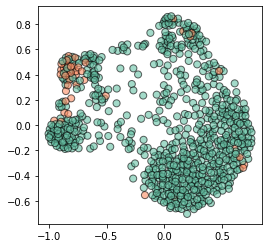

In [9]:
fig=plt.figure(figsize=(4,4))
plt.scatter(positions[0],positions[1],
            c=cm.get_cmap('Set2')(single_geneset_enrichment(df,graph_data,imd)[0]),
            alpha=0.6,ec='black',lw=1,
            s=50,zorder=2)

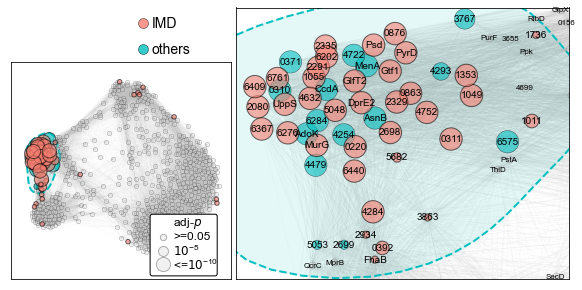

In [39]:
from matplotlib.patches import FancyBboxPatch



target_found, fdr, enriched, neglog10 = single_geneset_enrichment(df, graph_data, imd, pval_cutoff=0.04,
                                                                  edge_weight_percentage_cutoff=99)
fig=plt.figure(figsize=(10,5))
grids = gs(5,10,wspace=0.1,hspace=0.05)
ax1 = fig.add_subplot(grids[1:,:4])
ax2 = fig.add_subplot(grids[:,4:])
ax3 = fig.add_subplot(grids[0,:4])
ax3.axis('off')
#ax3 = fig.add_subplot(grids[0,8:])

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])



sizes = neglog10 / 10
sizes[sizes<-np.log10(0.04)/10] = 0.1
sizes[sizes>1]=1

edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.05, ax=ax1)

enriched_neighbors = np.where((target_found==0)&(sizes>0.1))[0]
outgroup = np.where((target_found==0)&(sizes==0.1))


ax1.scatter(positions[0,enriched_neighbors],positions[1,enriched_neighbors],
            c='c',
            alpha=0.6,ec='black',lw=1,
            s=sizes[enriched_neighbors]*200,zorder=2)
"""
ax1.scatter(positions[0,cog_atp],positions[1,cog_atp],
            c='orange',
            alpha=0.6,ec='black',lw=1,
            s=sizes[cog_atp]*200,zorder=2)
"""
ax1.scatter(positions[0,target_found==1],positions[1,target_found==1],
            c='salmon',
            alpha=0.6,ec='black',lw=1,
            s=sizes[target_found==1]*200,zorder=3)


ax1.scatter(positions[0,outgroup],positions[1,outgroup],
            c='lightgrey',
            alpha=0.3,ec='black',lw=0.5,
            s=20,zorder=2)

ax1.set_xlim(-1.2,0.9)
ax1.set_ylim(-0.85,1.05)
    
ax1 = ms.polygon_to_density(ax1,positions[0,sizes>0.1],positions[1,sizes>0.1],alpha_max=0.2,ngrid=100,
                            basecolor='c',outline_lw = 2,outline_ls='--',smooth_outline=10)

label_box = FancyBboxPatch((-1.05+1.2,-0.7-0.1),height=0.5,width=0.6,boxstyle='Round,pad=0.02',
                           fc='white',ec='black',zorder=4)
ax1.add_artist(label_box)

ax1.text(-0.85+1.2,-0.28-0.1,'adj-$\it{p}$',zorder=5,fontname='Arial',fontsize=12)

vals = [-np.log10(0.01)/10, -np.log10(0.00001)/10,-np.log10(0.0000000001)/10]
texts = ['>=0.05', '$10^\mathregular{-5}$','<=$10^\mathregular{-10}$']
labelsizes = np.array(vals)*200
for counter,y in enumerate([-0.38,-0.5,-0.62]):
    ax1.scatter(-0.95+1.2,y-0.1,s=labelsizes[counter],fc='lightgrey', ec='black',lw=1,alpha=0.3,zorder=6)
    ax1.text(-0.85+1.2,y-0.1,'{}'.format(texts[counter]),ha='left',va='center',fontname='Arial',fontsize=12,zorder=6)
    

ax2 = ms.polygon_to_density(ax2,positions[0,sizes>0.1],positions[1,sizes>0.1],alpha_max=0.0,
                            ngrid=100,
                            basecolor='c',outline_lw = 2,outline_ls='--',smooth_outline=10)

ax2.set_xlim(-1.015,-0.75)
ax2.set_ylim(-0.1,0.4)
edges2 = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.5,
                                ax=ax2)

ax2.scatter(positions[0,enriched_neighbors],positions[1,enriched_neighbors],
            c='c',
            alpha=0.6,ec='black',lw=0.5,
            s=sizes[enriched_neighbors]*500,zorder=2)
"""
ax2.scatter(positions[0,cog_atp],positions[1,cog_atp],
            c='orange',
            alpha=0.6,ec='black',lw=0.5,
            s=sizes[cog_atp]*500,zorder=2)
""";
ax2.scatter(positions[0,target_found==1],positions[1,target_found==1],
            c='salmon',
            alpha=0.6,ec='black',lw=1,
            s=sizes[target_found==1]*500,zorder=3)

ax2.scatter(positions[0,outgroup],positions[1,outgroup],
            c='lightgrey',
            alpha=0.3,ec='black',lw=0.5,
            s=50,zorder=2)

names=format_names(df['name'].values)
selected = zoom_in(positions[0],positions[1],-1.015,-0.75,-0.1,0.4)
for i in selected:
    x=positions[0,i]
    y=positions[1,i]
    s=names[i]
    if i in enriched or target_found[i]==1: 
        fontsize=10
    else:
        fontsize=8
    if s=='6288':
        x-=0.01
        y-=0.005
    ax2.annotate(s,(x,y),fontname='Arial',fontsize=fontsize,va='center',ha='center',
                 zorder=6)

ax3.text(0.64,0.7,'IMD',fontname='Arial',fontsize=14,zorder=6,ha='left',va='center')
ax3.scatter(0.6,0.7,fc='salmon',s=100,ec='black',lw=0.5,alpha=0.8)
ax3.text(0.64,0.2,'others',fontname='Arial',fontsize=14,zorder=6,ha='left',va='center')
ax3.scatter(0.6,0.2,fc='c',s=100,ec='black',lw=0.5,alpha=0.8)
ax3.set_ylim(0,1)
ax3.set_xlim(0,1)

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/imd_plots/imd_temp.png',
            dpi=100,bbox_inches='tight',transparent=True)

In [40]:
df.iloc[np.where(sizes>0.1)[0]].to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/imd_plots/imd_list.xlsx')

In [40]:
# plot consensus
imdstack = np.array([gematria_input[i,5,:] for i in np.where(target_found==1)[0]])
weightedstack = np.sum(imdstack*neglog10[target_found==1][:,np.newaxis],axis=0)
fig=plt.figure(figsize=(2,1))
plt.imshow(weightedstack.reshape(15,30),aspect='auto')
plt.axis('off')
#plt.title('weighted consensus\n(l=5)')
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/imd_plots/imd_weighted_consensus.png',
            dpi=100,bbox_inches='tight',transparent=True)
plt.close()

In [42]:
len(enriched)

47

In [44]:
len(np.where((target_found==1)&(sizes>0.1))[0])

32

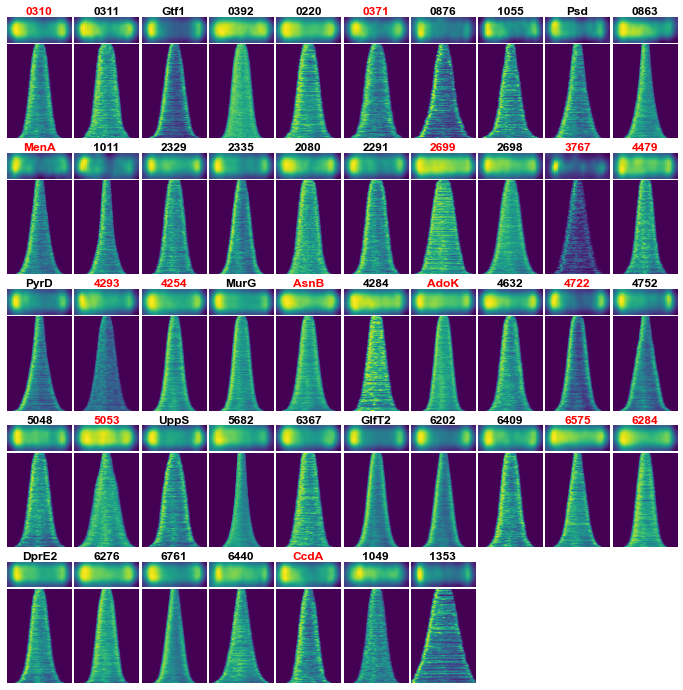

In [49]:
fig=plt.figure(figsize=(24/2,25/2))
names = format_names(df.iloc[enriched]['name'])
grids = gs(50,20,hspace=0.1,wspace=0.1)
for i in range(5):
    for j in range(10):
        k = i*10+j
        if k < len(enriched)-1:
            ax1 = fig.add_subplot(grids[i*10+1:i*10+3,j*2:j*2+2])
            consensus = gematria_input_filtered[enriched[k],5,:]
            ax1.imshow(consensus.reshape(15,30),aspect='auto')
            ax1.axis('off')
            ax2 = fig.add_subplot(grids[i*10+3:i*10+10,j*2:j*2+2])
            ax2.axis('off')
            key = df.iloc[enriched[k]]['key']
            if 'MSMEG_6761' in key:
                key = 'MSR_12_F10_MSMEG_6791'
            name = names[k]
            locus = df.iloc[enriched[k]]['locus']
            if target_found[enriched[k]]==1:
                color = 'black'
            else:
                color = 'red'
            title = ax1.set_title(name,fontname='Arial',fontsize=12,va='bottom',fontweight='bold',
                                  color=color,pad=0)
            straindata = pk.load(open('/Volumes/Junhao_data_Rubin_Lab/MSR_data_0411/{}/all_cells_miscellaneous_data.pk'.format(key),'rb'))
            sorted_id = straindata['sorted_filtered_id']
            ax2.imshow(straindata['FITC']['padded_axial_data'][sorted_id],aspect='auto')
        elif k == len(enriched)-1:
            ax1 = fig.add_subplot(grids[i*10+1:i*10+3,j*2:j*2+2])
            consensus = gematria_input_filtered[enriched[k],5,:]
            ax1.imshow(consensus.reshape(15,30),aspect='auto')
            ax1.axis('off')
            ax2 = fig.add_subplot(grids[i*10+3:i*10+10,j*2:j*2+2])
            ax2.axis('off')
            key = df.iloc[enriched[k]]['key']
            name = names[k]
            locus = df.iloc[enriched[k]]['locus']
            if target_found[enriched[k]]==1:
                color = 'black'
            else:
                color = 'red'
            title = ax1.set_title(name,fontname='Arial',fontsize=12,va='bottom',fontweight='bold',
                                  color=color,pad=0)
            header,channel = key.split('_')
            straindata = pk.load(open('/Volumes/Junhao_data_Rubin_Lab/MSR_spike_in_data/selected_output/{}/all_cells_miscellaneous_data.pk'.format(header),'rb'))
            sorted_id = straindata['sorted_filtered_id']
            ax2.imshow(straindata[channel]['padded_axial_data'][sorted_id],aspect='auto')
            
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/imd_plots/imd_strainpics.png',
            dpi=100,bbox_inches='tight',transparent=True)

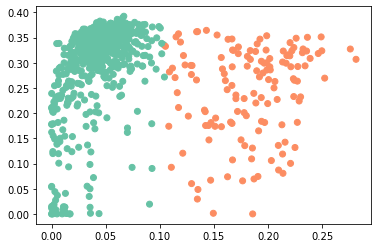

In [46]:
# define membrane proteins using a gaussian mixture model
from sklearn import mixture
from scipy import stats
mod = mixture.GaussianMixture(n_components=2,covariance_type='full')
feature_1 = np.average(reshaped[:,:,1],axis=1)
labels = mod.fit_predict(feature_1.reshape(-1,1))
plt.scatter(np.average(reshaped[:,:,1],axis=1),np.average(reshaped[:,:,0],axis=1),color=cm.get_cmap('Set2')(labels))

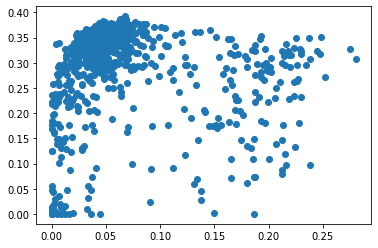

In [44]:
plt.scatter(np.average(reshaped[:,:,1],axis=1),np.average(reshaped[:,:,0],axis=1))

In [47]:
mod = mixture.GaussianMixture(n_components=2,covariance_type='full')
feature_1 = np.average(reshaped[:,:,0],axis=1)
feature_2 = np.average(reshaped[:,:,1],axis=1)
feature_4 = np.average(reshaped[:,:,3],axis=1)
feature_6 = np.average(reshaped[:,:,7],axis=1)
membrane_labels = mod.fit_predict(feature_2.reshape(-1,1))

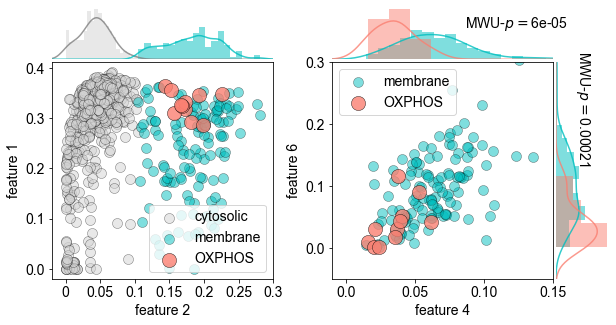

In [54]:
# define membrane proteins using a gaussian mixture model
from sklearn import mixture
from scipy import stats


membrane_ingroup = np.where((membrane_labels==1)&(target_found==1))[0]
membrane_outgroup = np.where((membrane_labels==1)&(target_found==0))[0]


fig=plt.figure(figsize=(12,5))
grids=gs(5,12,hspace=0.05,wspace=0.05)
ax1 = fig.add_subplot(grids[:1,:4])
ax2 = fig.add_subplot(grids[1:,:4])
ax1.axis('off')
ax1.hist(feature_2[membrane_labels==0],bins=20,alpha=0.5,color='lightgrey',density=True)
ax1.hist(feature_2[membrane_labels==1],bins=20,alpha=0.5,color='c',density=True)
ax1=pdf(ax1,feature_2[membrane_labels==0],-0.1,0.3,'grey',0.8,bandwidth=0.01)
ax1=pdf(ax1,feature_2[membrane_labels==1],-0.1,0.3,'c',0.8,bandwidth=0.01)


ax2.scatter(feature_2[membrane_labels==0],feature_1[membrane_labels==0],alpha=0.5,s=100,fc='lightgrey',ec='black',lw=0.5,label='cytosolic')
ax2.scatter(feature_2[membrane_outgroup],feature_1[membrane_outgroup],alpha=0.5,s=100,fc='c',ec='black',lw=0.5,label='membrane')
ax2.scatter(feature_2[membrane_ingroup],feature_1[membrane_ingroup],alpha=0.8,s=200,fc='salmon',ec='black',lw=0.5,label='OXPHOS',zorder=3)                             
                             
ax1.set_xlim(-0.02,0.3)
ax2.set_xlim(-0.02,0.3)
ax2.legend(prop={'family':'Arial','size':14})

ax2.set_xticks([0,0.05,0.1,0.15,0.2,0.25,0.3])
ax2.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25,0.3],fontname='Arial',fontsize=14)
ax2.set_yticks([0,0.1,0.2,0.3,0.4])
ax2.set_yticklabels(['0.0','0.1','0.2','0.3','0.4'],fontname='Arial',fontsize=14)
ax2.set_xlabel('feature 2',fontname='Arial',fontsize=14)
ax2.set_ylabel('feature 1',fontname='Arial',fontsize=14)

ax3 = fig.add_subplot(grids[1:,5:9])
ax3.scatter(feature_4[membrane_outgroup],feature_6[membrane_outgroup],alpha=0.5,s=100,fc='c',ec='black',lw=0.5,label='membrane',zorder=2)
ax3.scatter(feature_4[membrane_ingroup],feature_6[membrane_ingroup],alpha=0.8,s=200,fc='salmon',ec='black',lw=0.5,label='OXPHOS',zorder=3)
ax3.legend(prop={'family':'Arial','size':14})
ax3.set_xlim(-0.01,0.15)
ax3.set_ylim(-0.05,0.3)
ax3.set_xticks([0,0.05,0.1,0.15])
ax3.set_xticklabels(['0.0','0.05','0.10','0.15'],fontname='Arial',fontsize=14)
ax3.set_yticks([0,0.1,0.2,0.3])
ax3.set_yticklabels(['0.0','0.1','0.2','0.3'],fontname='Arial',fontsize=14)
ax3.set_xlabel('feature 4',fontname='Arial',fontsize=14)
ax3.set_ylabel('feature 6',fontname='Arial',fontsize=14)

ax4 = fig.add_subplot(grids[:1,5:9])
ax4.hist(feature_4[membrane_outgroup],bins=20,alpha=0.5,color='c',density=True);
ax4.hist(feature_4[membrane_ingroup],bins=3,alpha=0.5,color='salmon',density=True);
ax4=pdf(ax4,feature_4[membrane_outgroup],-0.1,0.3,'c',0.8,bandwidth=0.01)
ax4=pdf(ax4,feature_4[membrane_ingroup],-0.1,0.3,'salmon',0.8,bandwidth=0.01)
ax4.set_xlim(-0.01,0.15)
ax4.axis('off')
ax4.text(0.6,0.6,
         'MWU-$\it{p}=$'+'{}'.format(round(stats.mannwhitneyu(feature_4[membrane_ingroup],feature_4[membrane_outgroup])[1],5)),
         transform = ax4.transAxes,fontname='Arial',fontsize=14)

ax5 = fig.add_subplot(grids[1:,9])
ax5.hist(feature_6[membrane_outgroup],bins=20,alpha=0.5,color='c',density=True,orientation='horizontal');
ax5.hist(feature_6[membrane_ingroup],bins=3,alpha=0.5,color='salmon',density=True,orientation='horizontal');
ax5=pdf(ax5,feature_6[membrane_outgroup],-0.1,0.3,'c',0.8,bandwidth=0.02,orientation='v')
ax5=pdf(ax5,feature_6[membrane_ingroup],-0.1,0.3,'salmon',0.8,bandwidth=0.02,orientation='v')
ax5.text(0.5,1.05,
         'MWU-$\it{p}=$'+'{}'.format(round(stats.mannwhitneyu(feature_6[membrane_ingroup],feature_6[membrane_outgroup])[1],5)),
         transform = ax5.transAxes,fontname='Arial',fontsize=14,rotation=270,ha='center',va='top')
ax5.set_ylim(-0.05,0.3)
ax5.axis('off')

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/atp_plots/atp_polar_depletion.png',
            dpi=100,bbox_inches='tight',transparent=True)

(0.0, 33.070373302137284, -0.05, 0.3)

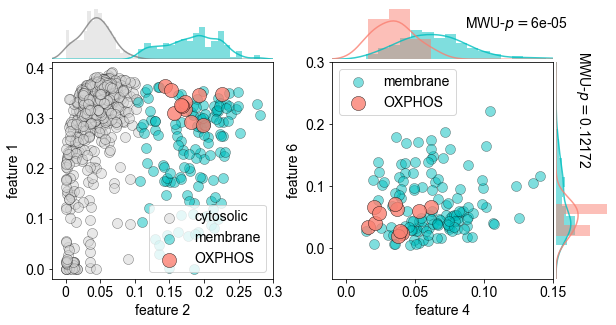

In [50]:
# define membrane proteins using a gaussian mixture model
from sklearn import mixture
from scipy import stats


membrane_ingroup = np.where((membrane_labels==1)&(target_found==1))[0]
membrane_outgroup = np.where((membrane_labels==1)&(target_found==0))[0]


fig=plt.figure(figsize=(12,5))
grids=gs(5,12,hspace=0.05,wspace=0.05)
ax1 = fig.add_subplot(grids[:1,:4])
ax2 = fig.add_subplot(grids[1:,:4])
ax1.axis('off')
ax1.hist(feature_2[membrane_labels==0],bins=20,alpha=0.5,color='lightgrey',density=True)
ax1.hist(feature_2[membrane_labels==1],bins=20,alpha=0.5,color='c',density=True)
ax1=pdf(ax1,feature_2[membrane_labels==0],-0.1,0.3,'grey',0.8,bandwidth=0.01)
ax1=pdf(ax1,feature_2[membrane_labels==1],-0.1,0.3,'c',0.8,bandwidth=0.01)


ax2.scatter(feature_2[membrane_labels==0],feature_1[membrane_labels==0],alpha=0.5,s=100,fc='lightgrey',ec='black',lw=0.5,label='cytosolic')
ax2.scatter(feature_2[membrane_outgroup],feature_1[membrane_outgroup],alpha=0.5,s=100,fc='c',ec='black',lw=0.5,label='membrane')
ax2.scatter(feature_2[membrane_ingroup],feature_1[membrane_ingroup],alpha=0.8,s=200,fc='salmon',ec='black',lw=0.5,label='OXPHOS',zorder=3)                             
                             
ax1.set_xlim(-0.02,0.3)
ax2.set_xlim(-0.02,0.3)
ax2.legend(prop={'family':'Arial','size':14})

ax2.set_xticks([0,0.05,0.1,0.15,0.2,0.25,0.3])
ax2.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25,0.3],fontname='Arial',fontsize=14)
ax2.set_yticks([0,0.1,0.2,0.3,0.4])
ax2.set_yticklabels(['0.0','0.1','0.2','0.3','0.4'],fontname='Arial',fontsize=14)
ax2.set_xlabel('feature 2',fontname='Arial',fontsize=14)
ax2.set_ylabel('feature 1',fontname='Arial',fontsize=14)

ax3 = fig.add_subplot(grids[1:,5:9])
ax3.scatter(feature_4[membrane_outgroup],feature_6[membrane_outgroup],alpha=0.5,s=100,fc='c',ec='black',lw=0.5,label='membrane',zorder=2)
ax3.scatter(feature_4[membrane_ingroup],feature_6[membrane_ingroup],alpha=0.8,s=200,fc='salmon',ec='black',lw=0.5,label='OXPHOS',zorder=3)
ax3.legend(prop={'family':'Arial','size':14})
ax3.set_xlim(-0.01,0.15)
ax3.set_ylim(-0.05,0.3)
ax3.set_xticks([0,0.05,0.1,0.15])
ax3.set_xticklabels(['0.0','0.05','0.10','0.15'],fontname='Arial',fontsize=14)
ax3.set_yticks([0,0.1,0.2,0.3])
ax3.set_yticklabels(['0.0','0.1','0.2','0.3'],fontname='Arial',fontsize=14)
ax3.set_xlabel('feature 4',fontname='Arial',fontsize=14)
ax3.set_ylabel('feature 6',fontname='Arial',fontsize=14)

ax4 = fig.add_subplot(grids[:1,5:9])
ax4.hist(feature_4[membrane_outgroup],bins=20,alpha=0.5,color='c',density=True);
ax4.hist(feature_4[membrane_ingroup],bins=3,alpha=0.5,color='salmon',density=True);
ax4=pdf(ax4,feature_4[membrane_outgroup],-0.1,0.3,'c',0.8,bandwidth=0.01)
ax4=pdf(ax4,feature_4[membrane_ingroup],-0.1,0.3,'salmon',0.8,bandwidth=0.01)
ax4.set_xlim(-0.01,0.15)
ax4.axis('off')
ax4.text(0.6,0.6,
         'MWU-$\it{p}=$'+'{}'.format(round(stats.mannwhitneyu(feature_4[membrane_ingroup],feature_4[membrane_outgroup])[1],5)),
         transform = ax4.transAxes,fontname='Arial',fontsize=14)

ax5 = fig.add_subplot(grids[1:,9])
ax5.hist(feature_6[membrane_outgroup],bins=20,alpha=0.5,color='c',density=True,orientation='horizontal');
ax5.hist(feature_6[membrane_ingroup],bins=3,alpha=0.5,color='salmon',density=True,orientation='horizontal');
ax5=pdf(ax5,feature_6[membrane_outgroup],-0.1,0.3,'c',0.8,bandwidth=0.02,orientation='v')
ax5=pdf(ax5,feature_6[membrane_ingroup],-0.1,0.3,'salmon',0.8,bandwidth=0.02,orientation='v')
ax5.text(0.5,1.05,
         'MWU-$\it{p}=$'+'{}'.format(round(stats.mannwhitneyu(feature_6[membrane_ingroup],feature_6[membrane_outgroup])[1],5)),
         transform = ax5.transAxes,fontname='Arial',fontsize=14,rotation=270,ha='center',va='top')
ax5.set_ylim(-0.05,0.3)
ax5.axis('off')

#plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/atp_plots/atp_polar_depletion.png',
#            dpi=100,bbox_inches='tight',transparent=True)